<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/03_Time_Series_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@gmail.com

# Import libraries

In [1]:
stable = True # True: latest version, False: stable version

import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -q
    else:
        !pip install git+https://github.com/timeseriesAI/tsai.git -q
    
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.4
fastai     : 2.1.5
fastcore   : 1.3.3
torch      : 1.7.0


# Time Series/ Sequence Transforms

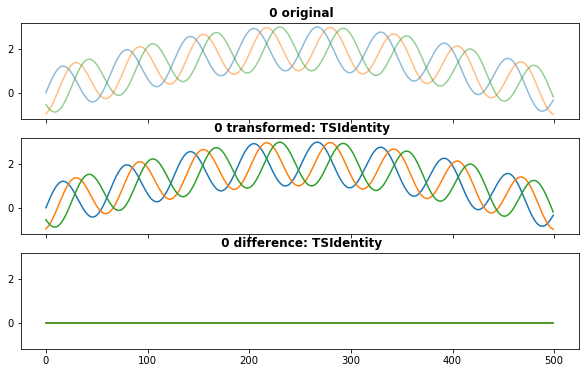

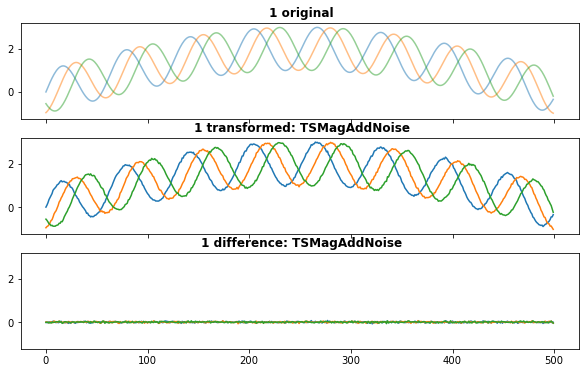

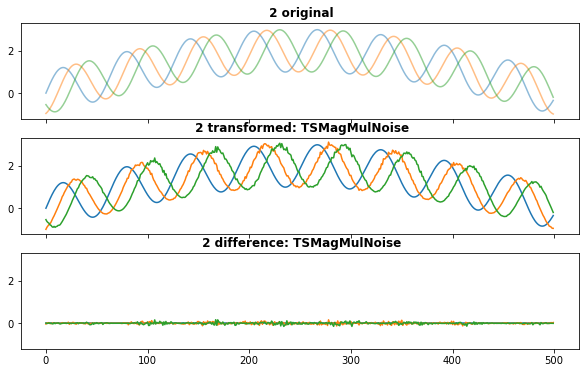

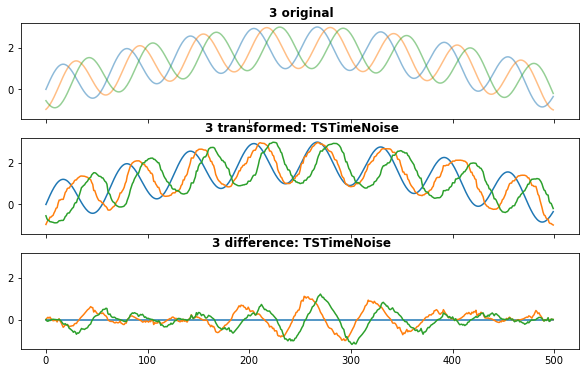

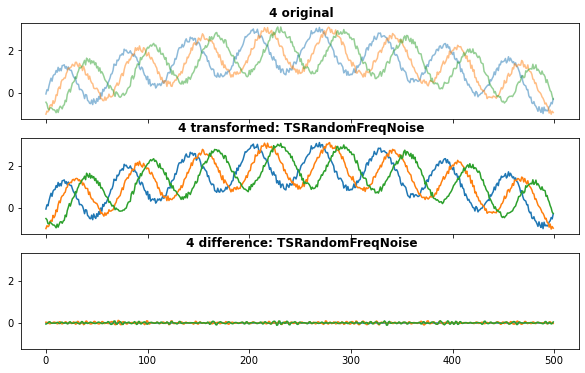

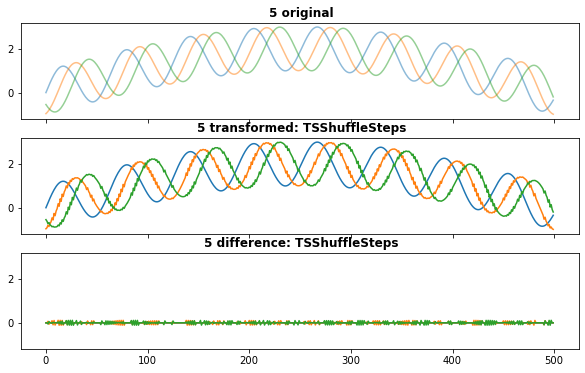

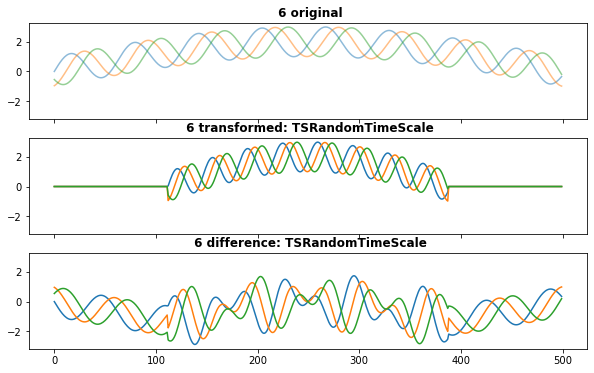

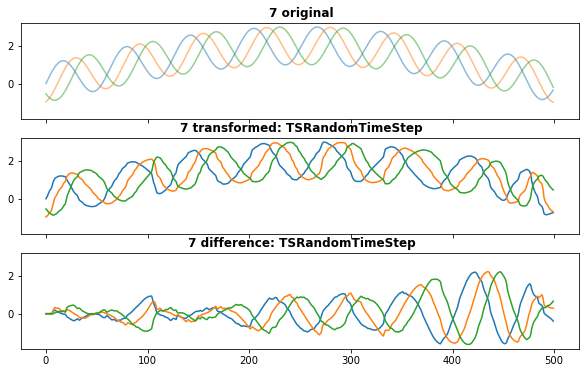

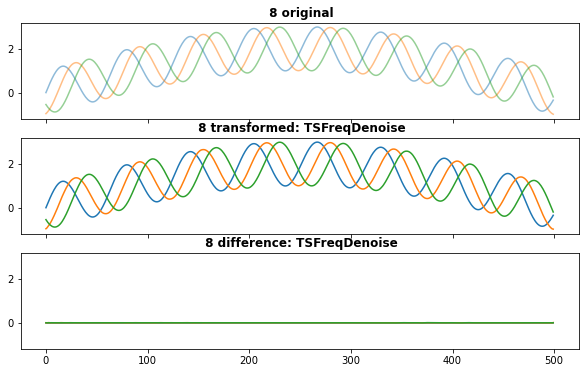

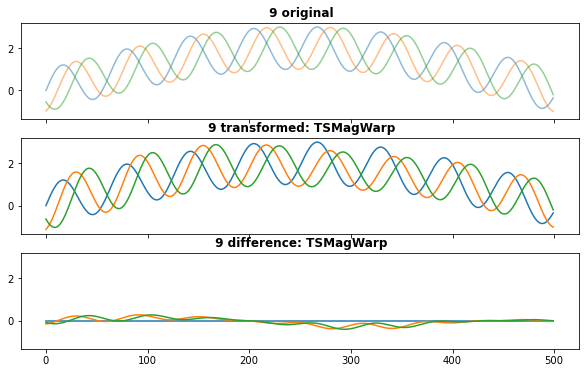

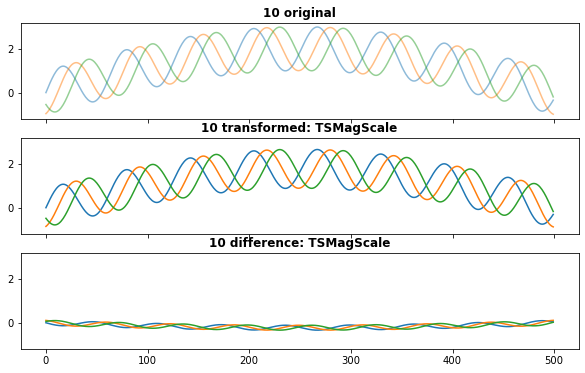

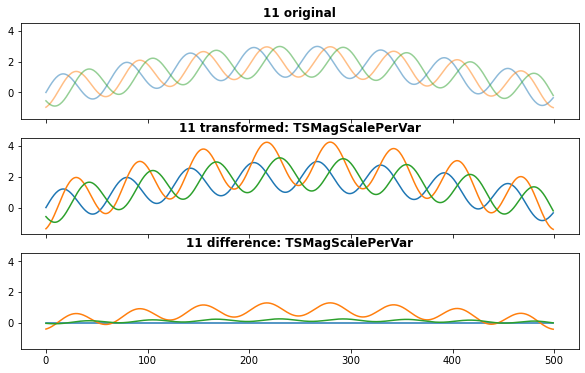

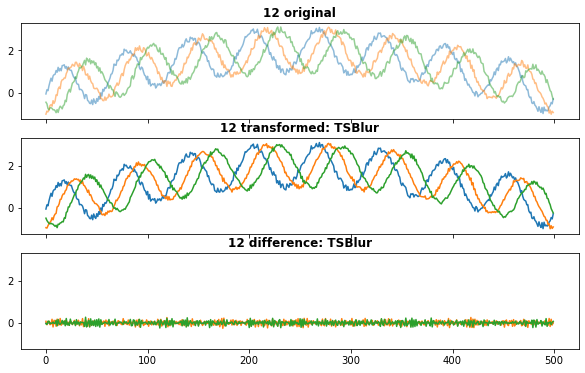

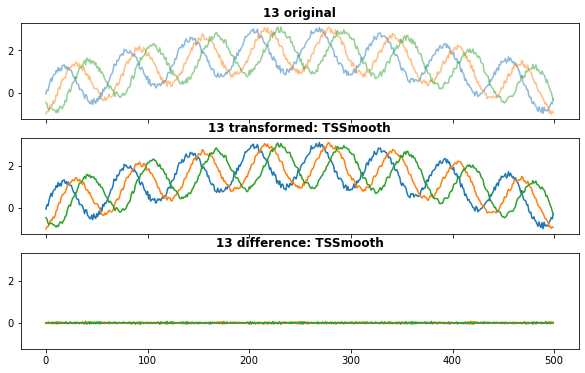

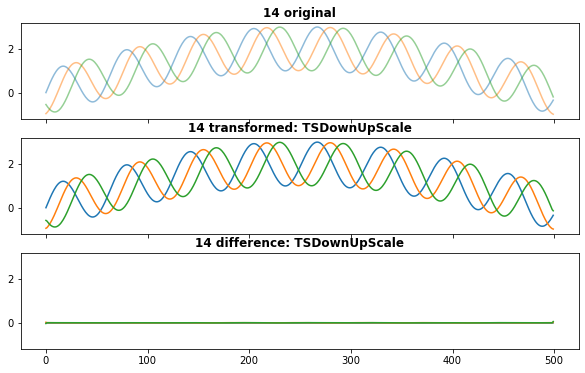

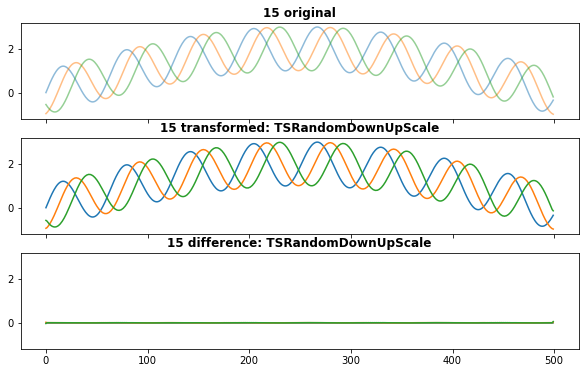

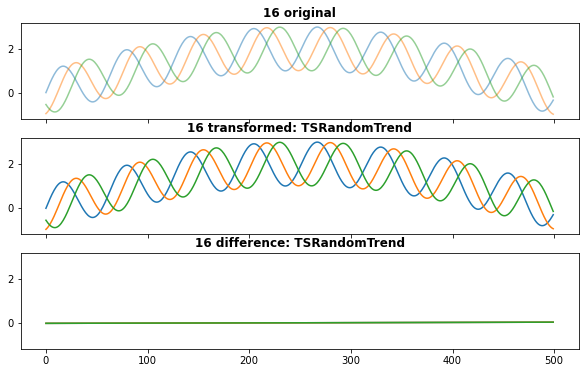

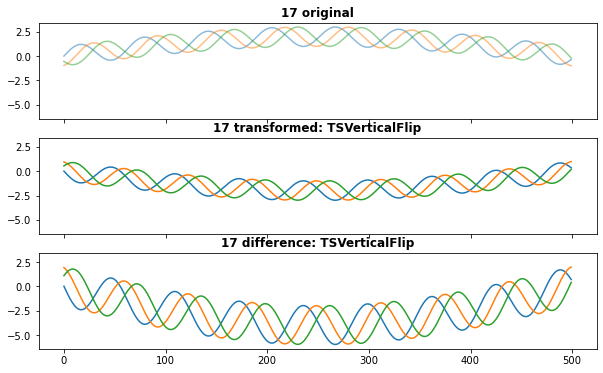

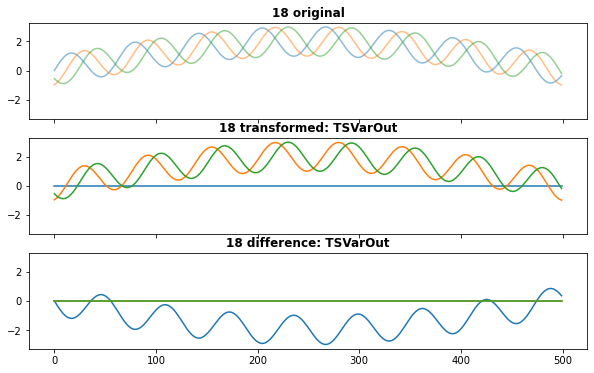

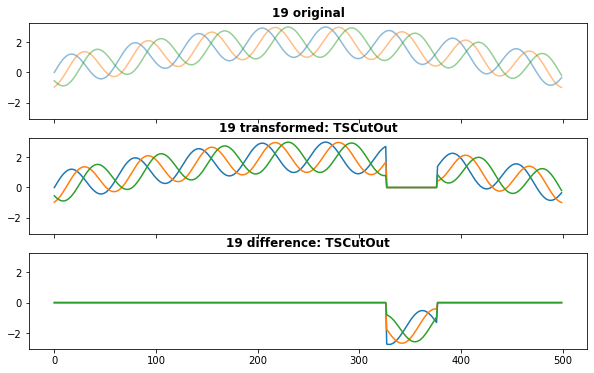

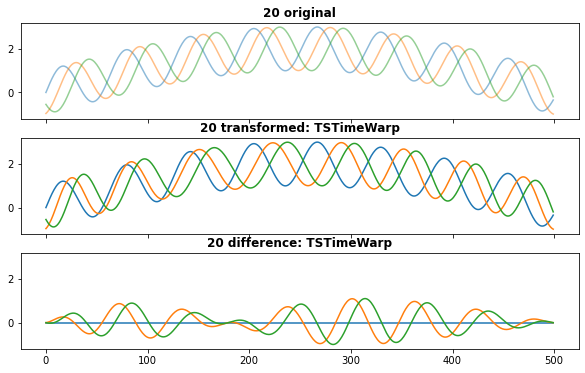

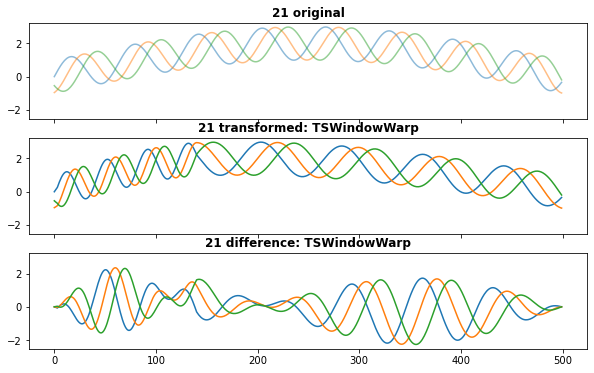

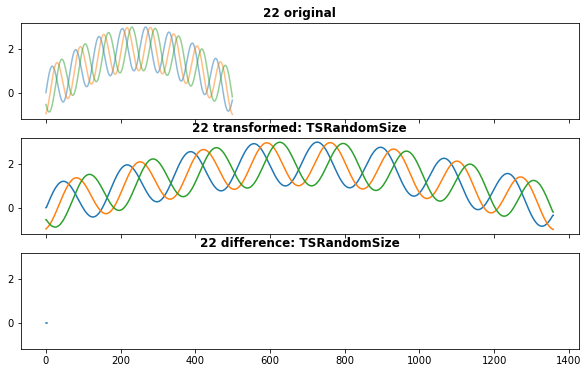

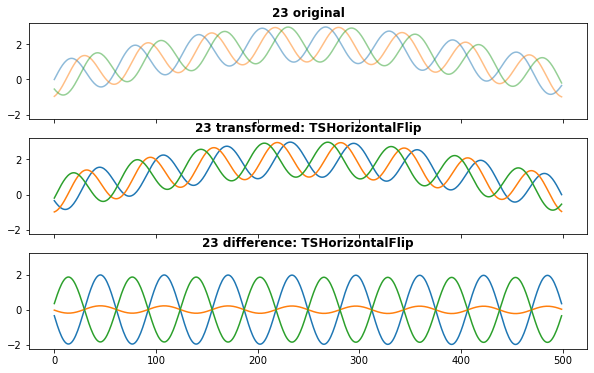

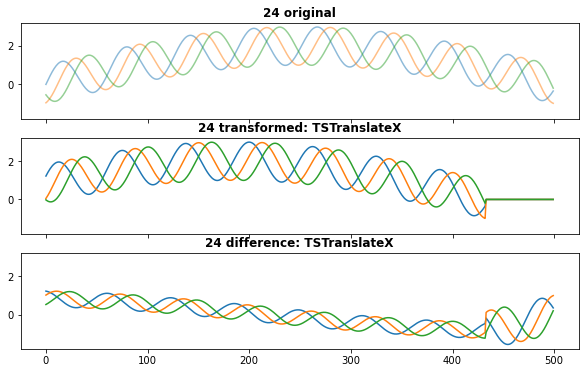

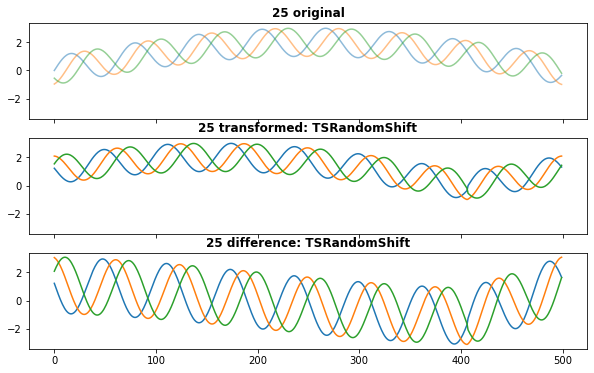

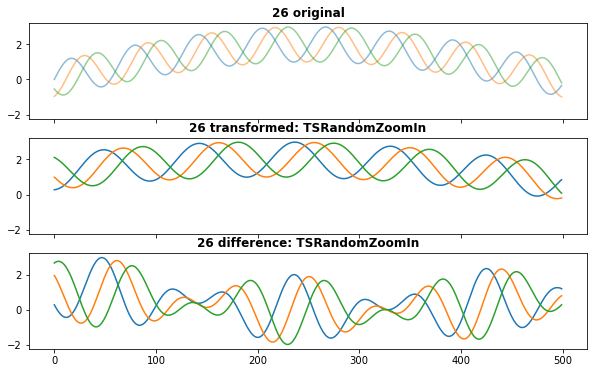

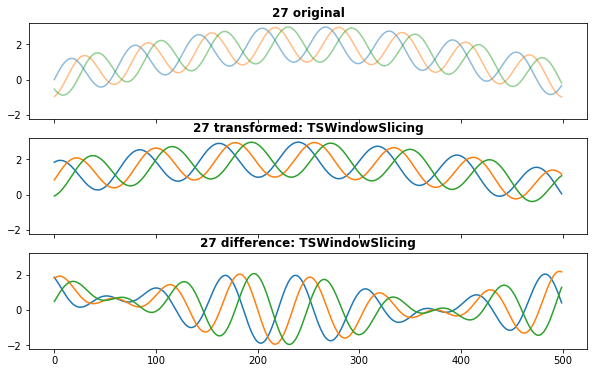

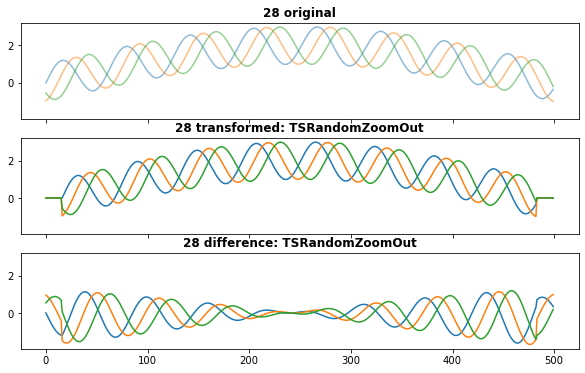

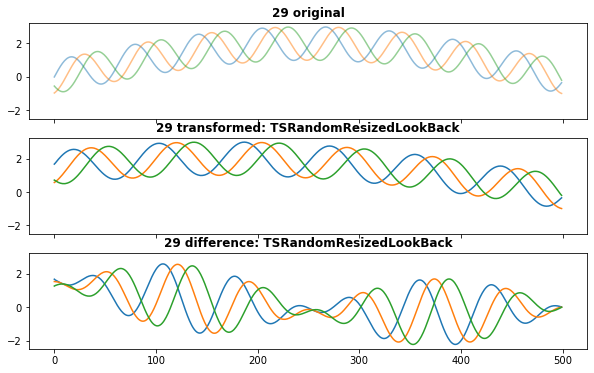

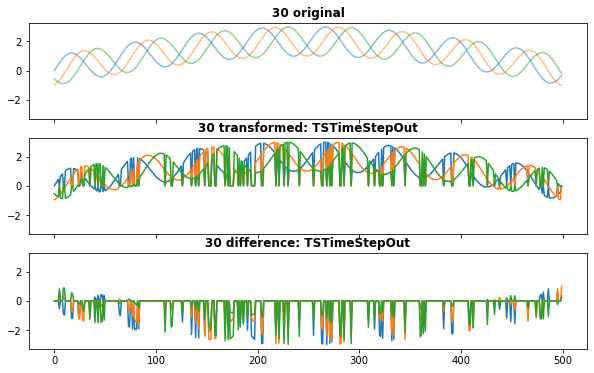

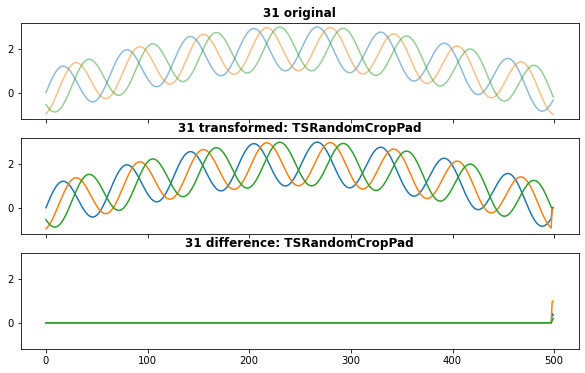

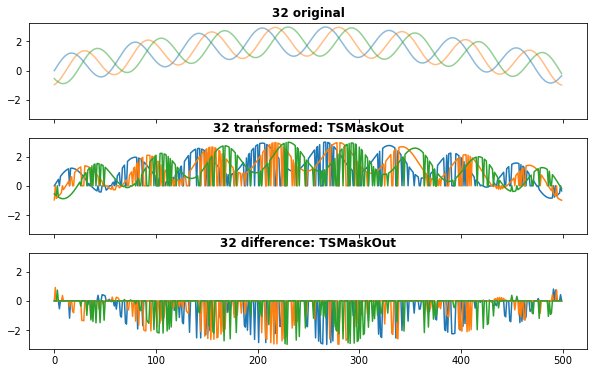

In [2]:
seq_len = 500
time = np.arange(0, seq_len/10, 0.1)
trend = np.sin(np.arange(0, 1, 1/seq_len)*np.pi)*2
a1 = np.sin(time)
a2 = np.sin(time + 5)
a3 = np.sin(time + 10)
na1 = a1 + np.random.rand(seq_len)*.3
na2 = a2 + np.random.rand(seq_len)*.3
na3 = a3 + np.random.rand(seq_len)*.3
signal = TSTensor(np.stack((a1,a2,a3), axis=0)[None])
signal -= signal.mean()
noisy_signal = TSTensor(np.stack((na1,na2,na3), axis=0)[None])
noisy_signal -= noisy_signal.mean()
multi_freq_signal = TSTensor((np.random.rand(3, seq_len) - .5).cumsum(-1))[None]
multi_freq_signal -= multi_freq_signal.mean()
multi_freq_signal /= multi_freq_signal.std()

start = 0
stop = 100
for i, tfm in enumerate(all_TS_randaugs[start:stop]):
    _tfm = tfm[0] if isinstance(tfm, tuple) else tfm
    tfm_name = _tfm.func.__name__ if isinstance(_tfm, functools.partial) else _tfm.__name__
    s = noisy_signal if tfm_name in ['TSBlur', 'TSSmooth', 'TSLowRes', 'TSRandomLowRes', 'TSDenoise', 'TSRandomNoise', 
                                     'TSRandomNoise', 'TSRandomFreqNoise'] else signal
    s += trend
    s = TSTensor(s)
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True, sharey=True)
    ax[0].plot(s[0].T, alpha=0.5)
    ax[0].set_title(f'{i:2} original', fontweight="bold")
    for _ in range(20):
        ts = RandAugment(tfm, N=5, M=10)(s, split_idx=0)
        if tfm_name == 'TSIdentity' or not torch.equal(s.data, ts.data): break
    ax[1].plot(ts[0].T)
    ax[1].set_title(f'{i:2} transformed: {tfm_name}', fontweight="bold")
    dif = (ts[0].T - s[0].T) if ts[0].T.shape == s[0].T.shape else np.zeros(len(s[0]))
    ax[2].plot(dif)
    ax[2].set_title(f'{i:2} difference: {tfm_name}', fontweight="bold")
    plt.show()
    print()
    print()
beep()

# Single transform

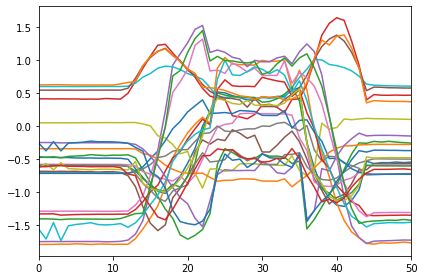

In [15]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', on_disk=True, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid)
xb, yb = next(iter(dls.train))
xb[0].show();

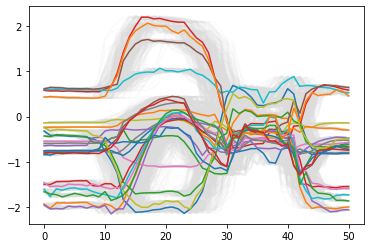

In [4]:
for i in range(100): plt.plot(TSTimeNoise(.5)(xb, split_idx=0)[0].T, color='gainsboro', alpha=.1)
plt.plot(xb[0].T)
plt.show()

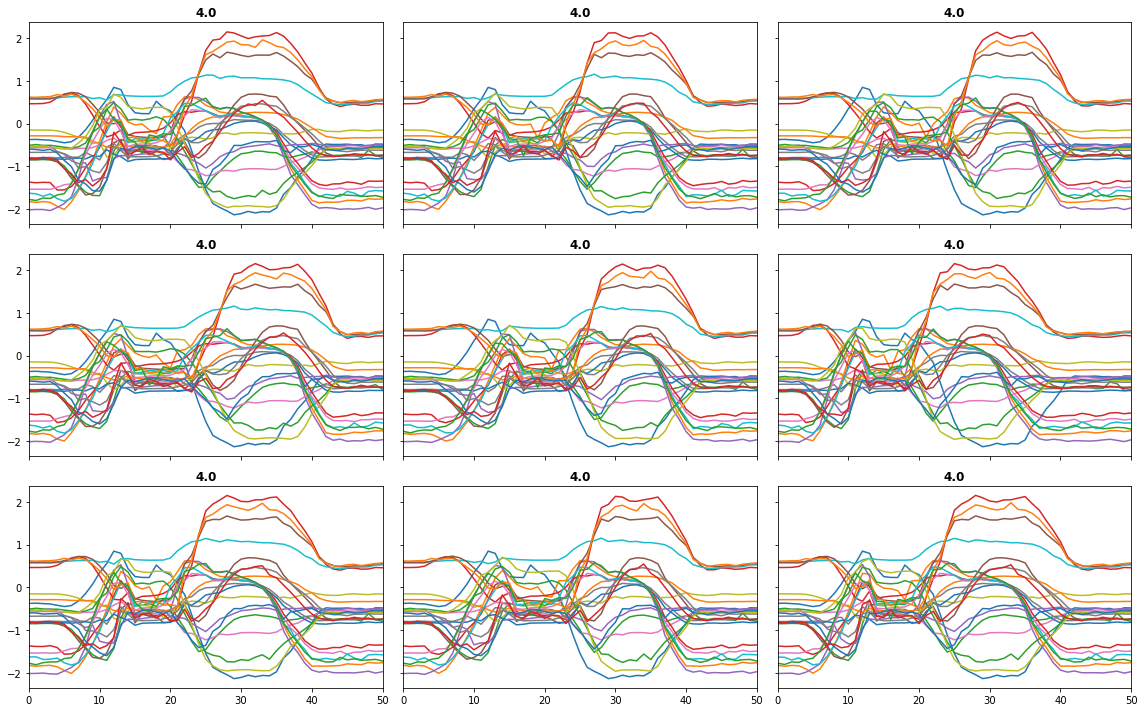

In [5]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, after_batch=[TSTimeWarp(magnitude=.2, ex=0)])
dls.show_batch(unique=True, sharex=True, sharey=True)

# Multiple transforms

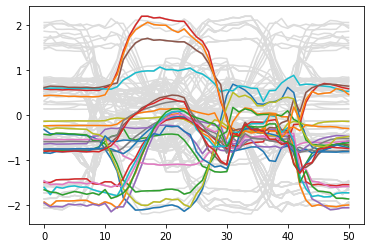

In [6]:
for i in range(10): plt.plot(compose_tfms(xb[0], [TSVerticalFlip(p=.5), TSHorizontalFlip(p=.5)], split_idx=0).T, color='gainsboro')
plt.plot(xb[0].T)
plt.show()

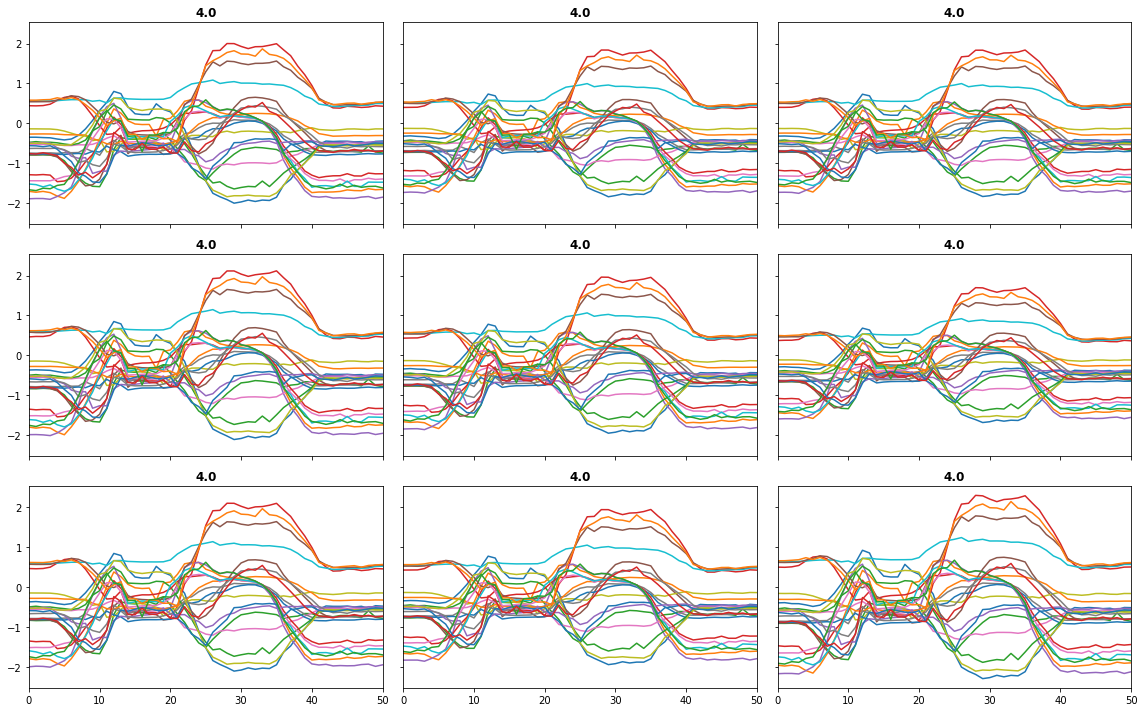

In [7]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=128, num_workers=0, batch_tfms=[TSMagAddNoise(magnitude=0.05), TSMagScale()])
dls.train.show_batch(unique=True, sharex=True, sharey=True)

In [8]:
BB_tfms = [TSIdentity, TSMagScale, partial(TSRandomTimeStep), partial(TSTimeWarp, ex=0), 
           TSRandomRotate,partial(TSMagWarp, ex=0), partial(TSTimeNoise, ex=0)]
for i in range(10): 
    xb2 = RandAugment(BB_tfms, N=3, M=1)(xb, split_idx=0)
    test_eq(xb2.shape, xb.shape)
    assert not np.array_equal(xb2.data, xb.data)

In [9]:
BB_tfms = [
    (TSIdentity, 0., 1.),
    (TSMagScale, .02, .2),
    (partial(TSRandomTimeStep), .02, .2),
    (partial(TSTimeWarp, ex=[0,1,2]), .02, .2),
    (TSRandomRotate, .1, .5),
    (partial(TSMagWarp, ex=0), .02, .2),
    (partial(TSTimeNoise, ex=0), .05, .5),
]
for i in range(10): 
    xb2 = RandAugment(BB_tfms, N=3, M=1)(xb, split_idx=0)
    test_eq(xb2.shape, xb.shape)
    assert not np.array_equal(xb2.data, xb.data)

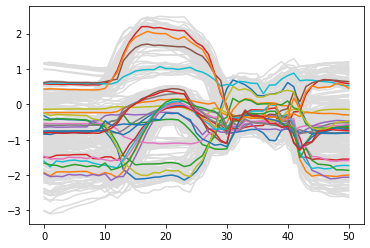

In [10]:
for i in range(20): plt.plot(RandAugment(BB_tfms, N=3, M=5)(xb, split_idx=0)[0].T, color='gainsboro')
plt.plot(xb[0].T)
plt.show()

# How to use time-series transforms?

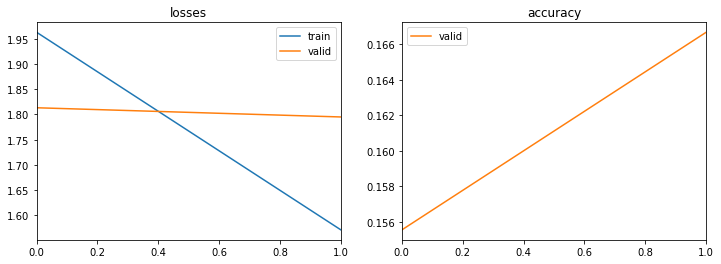

In [11]:
dsid = 'NATOPS' 
X, y, splits = get_UCR_data(dsid, return_split=False)

# type/ item transforms
tfms  = [None, [Categorize()]]

# batch transforms
TS_tfms = [
    TSIdentity,
    TSMagAddNoise,
    (TSMagScale, .02, .2),
    (partial(TSMagWarp, ex=0), .02, .2),
    (partial(TSTimeWarp, ex=[0,1,2]), .02, .2),
]
batch_tfms=[TSStandardize(), RandAugment(TS_tfms, N=3, M=5)]

dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=batch_tfms)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(2, lr_max=1e-3)
learn.recorder.plot_metrics()